# Text classification for customer complaints using Supervised Machine Learning algorithms. 

I create this project as a tutorial of a pipeline of the creation of a supervised machine learning classificator of financial customer complaints. I used the database from the Consumer Financial Protection Bureau, which you can find [here](https://www.consumerfinance.gov/data-research/consumer-complaints/)

I also used parts of the code for feature engineering and model implementation from the excellent tutorial made by Miguel Fernandez, which you can find [here](https://towardsdatascience.com/text-classification-in-python-dd95d264c802).

Lets start calling the libraries I will used in the notebook:

In [50]:
import pandas as pd
import numpy as np
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV,ShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve,auc
from scipy import interp
from itertools import cycle

After we have loaded the libraries, I will import the dataset from the csv file:

In [2]:
db=pd.read_csv("Consumer_Complaints.csv") #read the csv file

C:\Users\david\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The shape of this file can be obtained using the bd.shape option:

In [3]:
db.shape                                           #identify the number of rows.

(1390695, 18)

Then, the total number of complaints is 1.390.695. However, a few of them has the consumer complaint narrative blank. I will erase those rows and then again count the total number of complaints:

In [4]:
db=db[db['Consumer complaint narrative'].notna()] #eliminate the rows with na
db.shape                                          #identify the number of rows.

(442863, 18)

The number of complaints is reduced drastically to 442,863. That means, 947.832 complaints less, or 68,1% less. 

To make the histogram, we are going to processing the company column, create a counter object, and then mutate it with the companies and the frecuency of complaints. 

Text(0, 0.5, '# of complaints')

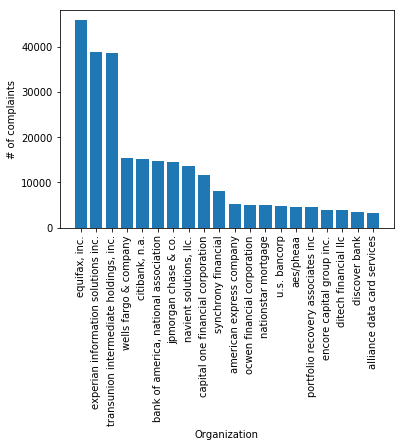

In [5]:
db_companies=db['Company'].tolist() #select only the column company for the analysis
org_counter=Counter()               #create a counter object
for i in db_companies:              #mutate the counter object
    org_counter[i.lower()]+=1

result=dict(org_counter.most_common(20)) #take only the 20 companies with higher number of complaints
plt.bar(result.keys(),result.values())   #plot the histogram
plt.xticks(rotation='vertical')
plt.xlabel('Organization')
plt.ylabel('# of complaints')

As I can see, almost 1 of 3 complaints is filed against one of the three credit score agencies in the country (Equifax, Experian or Transunion).

Now, I can build the Supervised Machine Learning model:

# Supervised Models:

Before I start the building of the model, I must prepare the data and build the TF-DF matrix. I must declare that part of the code and the procedures was inspired by this blog and the corresponding notebooks: https://towardsdatascience.com/text-classification-in-python-dd95d264c802
I will use nltk and scki-learn for that:

In [6]:
data_models=db[['Product','Consumer complaint narrative']]  #select only the columns of interest.
data_models.columns=['product', 'text']                     #change the name of the columns for simpler ones
categories=set()                                            #create an empy set
for i in data_models['product'].values.tolist():            #mutate all different type of products to the set
    categories.add(i)
print(categories)                                           #print the different type of complaints

{'Consumer Loan', 'Credit reporting', 'Checking or savings account', 'Student loan', 'Prepaid card', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Bank account or service', 'Payday loan', 'Other financial service', 'Payday loan, title loan, or personal loan', 'Virtual currency', 'Debt collection', 'Mortgage', 'Credit reporting, credit repair services, or other personal consumer reports', 'Vehicle loan or lease', 'Credit card or prepaid card', 'Credit card'}


Text(0, 0.5, '# of complaints')

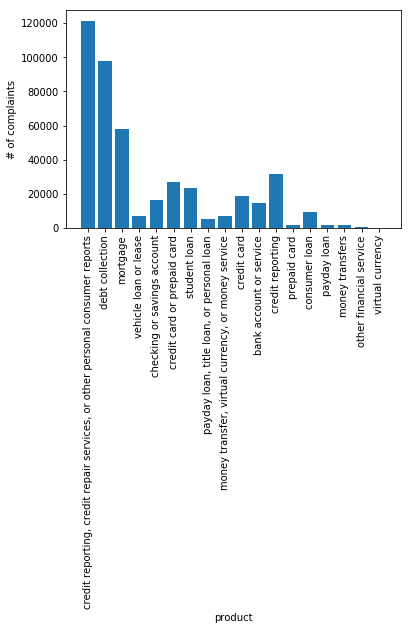

In [7]:
data_models_plot=data_models['product'].tolist() #select only the column company for the analysis
prod_counter=Counter()               #create a counter object
for i in data_models_plot:              #mutate the counter object
    prod_counter[i.lower()]+=1
plt.bar(prod_counter.keys(),prod_counter.values())   #plot the histogram
plt.xticks(rotation='vertical')
plt.xlabel('product')
plt.ylabel('# of complaints')

There is a huge imbalance between each category, as well as large ammount of products. For fix the latter and may be the former, I'm going to group in categories:

- Credit reporting: "credit reporting, credit repair services, or other personal consumer reports', "credit reporting".
- Debt collection: "debt collection".
- Loans: "mortgage, "vehicle loan or lease", "credit card or prepait card", "student loan", "payday loan, title loan, or personal loan", "credit card", "consumer loan", "payday loan", prepaid card"
- Financial service: "checking or savings account", "money transfer, virtual currency or money service", "bank account or service", "money transfers", "other financial service", "virtual currency"

In [8]:
product_new={"credit reporting, credit repair services, or other personal consumer reports":1,
            "credit reporting":1,
            "debt collection":2,
            "mortgage":3,
            "vehicle loan or lease":3,
            "credit card or prepait card":3,
            "student loan":3,
            "payday loan, title loan, or personal loan":3,
            "credit card":3,
            "consumer loan":3,
            "payday loan":3,
            "prepaid card":3,
            "checking or savings account":4,
            "credit card or prepaid card":4,
            'money transfer, virtual currency, or money service':4,
            "bank account or service":4,
             "money transfers":4,
             "other financial service":4,
             "virtual currency":4
            }
data_models['product_code'] = data_models['product'].str.lower()
data_models = data_models.replace({'product_code':product_new})

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
data_models_plot=data_models['product_code'].tolist() #select only the column company for the analysis
prod_counter=Counter()               #create a counter object
for i in data_models_plot:              #mutate the counter object
    prod_counter[i]+=1
plt.bar(prod_counter.keys(),prod_counter.values())   #plot the histogram
plt.xticks(rotation='vertical')
plt.xlabel('product code')
plt.ylabel('# of complaints')

And now I have a more balanced dataset. 

I prepared the data eliminating any special character (\r,\n), extra space ("   "), quoting (""), punctuation or possesive pronoun sign that the text may have, as well as transform the text to lower case:

In [ ]:
data_models['text_parsed1'] = data_models['text'].str.replace("\r", " ")    #eliminate the \r
data_models['text_parsed1'] = data_models['text'].str.replace("\n", " ")    #eliminate the \n
data_models['text_parsed1'] = data_models['text'].str.replace("    ", " ")   #eliminate extra space.
data_models['text_parsed1'] = data_models['text'].str.replace('"', '')       #eliminate the ""
data_models['text_parsed1'] = data_models['text'].str.lower()                #lower case
punctuation_signs = list("?:!.,;")                                           #create a small list of punctuation signs
for punct_sign in punctuation_signs: 
    data_models['text_parsed1'] = data_models['text_parsed1'].str.replace(punct_sign, '') #remove punctuation
data_models['text_parsed1'] = data_models['text_parsed1'].str.replace("'s", "")           #eliminate pronouns

Now, I can proceed to lemmatization, in order to have the morpholical root of the word: 

*The next three chunks of code will take about one hour. To go right to the final dataset, below you will find a command to load it. 

In [ ]:
nltk.download('punkt')                              # Downloading punkt and wordnet from NLTK
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()                    # Saving the lemmatizer into an object

lemm_list = []

for row in data_models['text_parsed1'].values.tolist():
    lemmatized_list = []                            # Create an empty list containing lemmatized words
    text = row                                      # Save the text and its words into an object
    text_words = text.split(" ")
    for word in text_words:                         # Iterate through every word to lemmatize
        lemmatized_list.append(lemmatizer.lemmatize(word, pos="v"))
    lemmatized_text = " ".join(lemmatized_list)     # Join the list
    lemm_list.append(lemmatized_text)               # Append to the list containing the texts

In [ ]:
data_models['text_parsed2']=lemm_list

After this, I will eliminate the stop words in english, using the dictionary of the nltk library.

In [ ]:
nltk.download('stopwords')                                              #Download the dictionary of stopwords
stop_words = list(stopwords.words('english'))                           #select the dictionary of english
regex = r"\b" + word + r"\b"                                            #build a regular expression for eliminate stop
for stop_word in stop_words:                                            #identify and eliminate stopwords in the text
    regex_stopword = r"\b" + stop_word + r"\b"
    data_models['text_parsed3'] = data_models['text_parsed2'].str.replace(regex_stopword, '')

Now that I have the features well defined, I will divide the dataset between train (70%) and test (30%):

In [12]:
data_models=pd.read_csv("feature_pre.csv") ## Run this to upload the final doc of features. 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_models['text_parsed3'],  #split the train, test data
                                                    data_models['product_code'],
                                                    test_size=0.30,               # 30% for the test data
                                                    random_state=8)

I will also transform train and test dataset into the TF-IDF matrix, so I can use that for the supervise marchine learning. For computational simplicity, I will only use unigrams, and the maximum features in the dictionary of the matrix is 300:

In [14]:
min_df = 10                                                             #minimum inverse term frequency 
max_df = 1.                                                             # maximum inverse term frequency to be considered
max_features = 300                                                      # only consider 300 highest words with TF-IDF

fidf = TfidfVectorizer( stop_words=None,                                #set up the count vectorizer
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
features_train = fidf.fit_transform(X_train).toarray()                  # apply the count vectorizer to both train and
labels_train = y_train                                                  # test datasets and obtain the size of the matrix
print(features_train.shape)

features_test = fidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(310004, 300)
(132859, 300)


Now that I have the TF-IDF matrix, I can run the supervised models. I will run a multinomial Naive Bayes and a random forest, to compair its performance:

In [15]:
# Multinomial naive bayes:
mnbc = MultinomialNB()                                             #set up the model
mnbc_fitted=mnbc.fit(features_train, labels_train)                 #fit the model to the training data
score_cv_mnbc=cross_val_score(mnbc, features_train, labels_train, cv=5) #fit the model using cross validation
mnbc_pred = mnbc.predict(features_test)                            #predict on the test dataset

Now, I can have the mean of the accuracy for the cross validation method on the test dataset:

In [16]:
score_cv_mnbc.mean()

0.735545357116479

The probability for each class is:

In [65]:
mnbc_pred_prob=mnbc.predict_proba(features_test)

Then, the mean of the 5-fold accuracy for the Naive bayes is 73%. I can build a confussion matrix to see where the model is making the mistakes. 

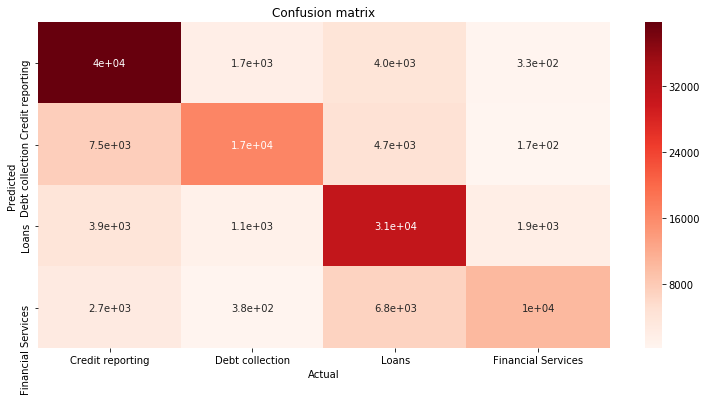

In [28]:
#aux_data = data_models[['product', 'product_code']].drop_duplicates().sort_values('product_code')
aux_data = pd.DataFrame({'product':["Credit reporting", "Debt collection", "Loans","Financial Services"],
                       'product_code':[1,2,3,4]})
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_data['product'].values, 
            yticklabels=aux_data['product'].values,
            cmap="Reds")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

From the matrix, we can see that Credit reporting and loans are two categories with good classification. Debt collection is the weaker. With this in mind, I will set up the logistic classificator. For the parameter tunning, I will set up a random search grid, and then, focus the search arround a particular grid.

In [20]:
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]         # create the grid for hyperparameter tunn
multi_class = ['multinomial']                                                #multinomial class
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']                               # type of solver
class_weight = ['balanced', None]                                            # class weight
penalty = ['l2']                                                             # penalty
random_grid = {'C': C,                                                       #random grid
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}
lrc = LogisticRegression(random_state=8)                                     #call the logistic regression
random_search = RandomizedSearchCV(estimator=lrc,                           # Definition of the random search
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

random_search.fit(features_train, labels_train)                               # Fit the random search model
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\david\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\david\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\david\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\david\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\david\AppData\Roaming\Python\P

C:\Users\david\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\david\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 65.2min finished


The best hyperparameters from Random Search are:
{'solver': 'sag', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': None, 'C': 0.30000000000000004}

The mean accuracy of a model with these hyperparameters is:
0.7962155327028039


In [20]:
C = [float(x) for x in np.linspace(start = 0.3, stop = 1, num = 10)] # Create the parameter grid
multi_class = ['multinomial']                                        # based on the results of random search 
solver = ['sag']
class_weight=[None]
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}
lrc = LogisticRegression(random_state=8)                             # Create a base model
cv_sets = ShuffleSplit(n_splits = 5, test_size = .20, random_state = 8) # Manually create the splits in CV in order to be able
grid_search = GridSearchCV(estimator=lrc,                           # Instantiate the grid search model
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(features_train, labels_train)                       # Fit the grid search to the data
best_lrc = grid_search.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 35.1min finished


Then, the optimal logistical regression is:

In [21]:
best_lrc

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=8, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

Then, the final logistic regression is:

In [40]:
#best_lrc.fit(features_train, labels_train)
lrc_pred = best_lrc.predict(features_test)

In [32]:
lrc_pred_prob = best_lrc.predict_proba(features_test)

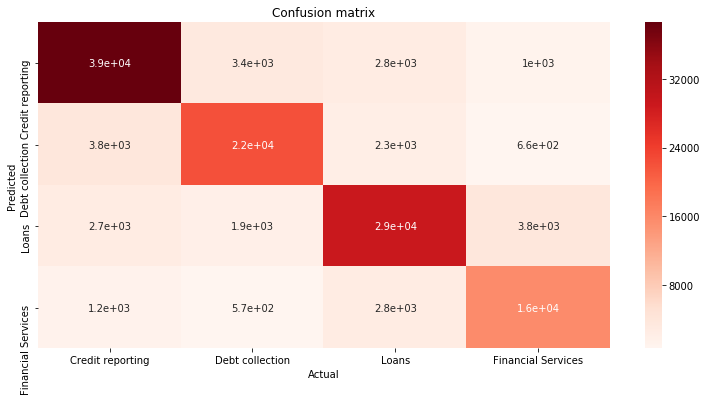

In [22]:
aux_data = pd.DataFrame({'product':["Credit reporting", "Debt collection", "Loans","Financial Services"],
                       'product_code':[1,2,3,4]})
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_data['product'].values, 
            yticklabels=aux_data['product'].values,
            cmap="Reds")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

Now, it would be nice to have a non-linear model, such as a SVM or Random Forest. However, those models are very computational expensive, and for time constraints, I will only fit the two models above. For evaluating both models, I will use the ROC curve in order to see if there is any dominant model. Because I'm dealing with a multi class classification problem, I will plot the ROC curve for each class and the average for each model separately, and then the comprarisons for each class and the average. Let's start with the ROC curves for the naive Bayes model:

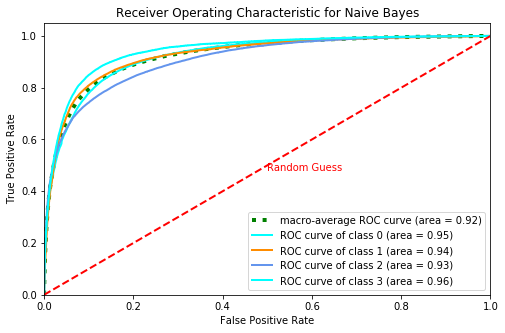

In [72]:
n_classes = 4
t1=sum(x==0 for x in mnbc_pred-labels_test) /len(lrc_pred)

#### MACRO
fpr_naive = dict()
tpr_naive = dict()
roc_auc_naive = dict()

for i in range(n_classes):
    #fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(labels_test))[:, i], np.array(pd.get_dummies(lrc_pred))[:, i])
    fpr_naive[i], tpr_naive[i], _ = roc_curve(np.array(pd.get_dummies(labels_test))[:, i], np.array(mnbc_pred_prob)[:, i])
    roc_auc_naive[i] = auc(fpr_naive[i], tpr_naive[i])
all_fpr_naive = np.unique(np.concatenate([fpr_naive[i] for i in range(n_classes)]))

mean_tpr_naive = np.zeros_like(all_fpr_naive)
for i in range(n_classes):
    mean_tpr_naive += interp(all_fpr_naive, fpr_naive[i], tpr_naive[i])

mean_tpr_naive /= n_classes

fpr_naive["macro"] = all_fpr_naive
tpr_naive["macro"] = mean_tpr_naive
roc_auc_naive["macro"] = auc(fpr_naive["macro"], tpr_naive["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr_naive["macro"], tpr_naive["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_naive["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_naive[i], tpr_naive[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Naive Bayes')
plt.legend(loc="lower right")
plt.show()

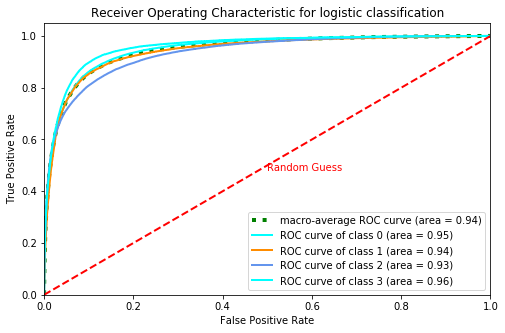

In [68]:
n_classes = 4
t1=sum(x==0 for x in lrc_pred-labels_test) /len(lrc_pred)

#### MACRO
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    #fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(labels_test))[:, i], np.array(pd.get_dummies(lrc_pred))[:, i])
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(labels_test))[:, i], np.array(lrc_pred_prob)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for logistic classification')
plt.legend(loc="lower right")
plt.show()

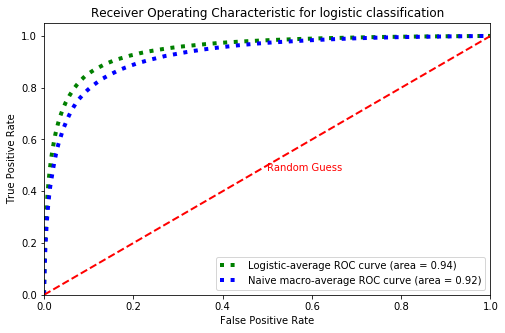

In [73]:
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='Logistic-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)
plt.plot(fpr_naive["macro"], tpr_naive["macro"],
         label='Naive macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_naive["macro"]),
         color='blue', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for logistic classification')
plt.legend(loc="lower right")
plt.show()


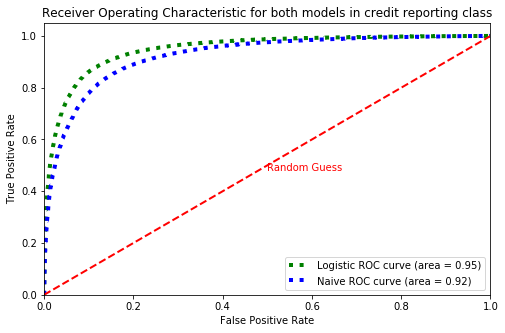

In [78]:
plt.figure(figsize=(8,5))
plt.plot(fpr[0], tpr[0],
         label='Logistic ROC curve (area = {0:0.2f})'
               ''.format(roc_auc[0]),
         color='green', linestyle=':', linewidth=4)
plt.plot(fpr_naive[0], tpr_naive[0],
         label='Naive ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_naive[0]),
         color='blue', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for both models in credit reporting class')
plt.legend(loc="lower right")
plt.show()

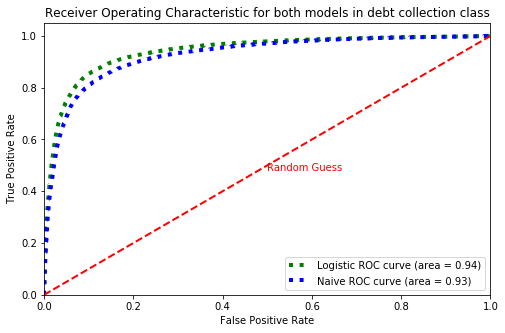

In [79]:
plt.figure(figsize=(8,5))
plt.plot(fpr[1], tpr[1],
         label='Logistic ROC curve (area = {0:0.2f})'
               ''.format(roc_auc[1]),
         color='green', linestyle=':', linewidth=4)
plt.plot(fpr_naive[1], tpr_naive[1],
         label='Naive ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_naive[1]),
         color='blue', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for both models in debt collection class')
plt.legend(loc="lower right")
plt.show()

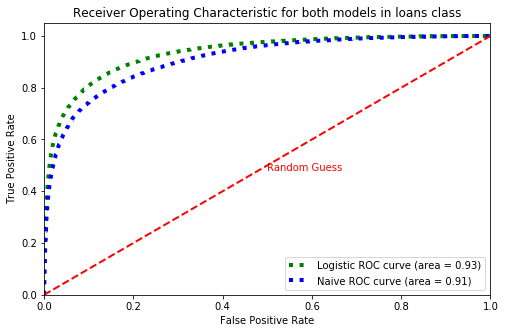

In [80]:
plt.figure(figsize=(8,5))
plt.plot(fpr[2], tpr[2],
         label='Logistic ROC curve (area = {0:0.2f})'
               ''.format(roc_auc[2]),
         color='green', linestyle=':', linewidth=4)
plt.plot(fpr_naive[2], tpr_naive[2],
         label='Naive ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_naive[2]),
         color='blue', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for both models in loans class')
plt.legend(loc="lower right")
plt.show()

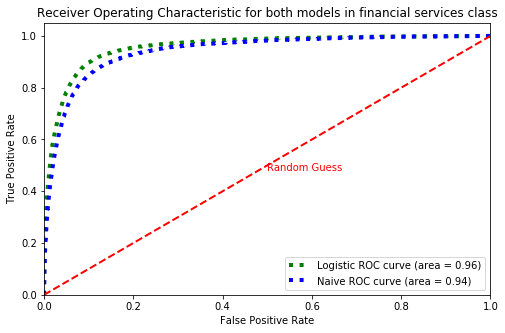

In [81]:
plt.figure(figsize=(8,5))
plt.plot(fpr[3], tpr[3],
         label='Logistic ROC curve (area = {0:0.2f})'
               ''.format(roc_auc[3]),
         color='green', linestyle=':', linewidth=4)
plt.plot(fpr_naive[3], tpr_naive[3],
         label='Naive ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_naive[3]),
         color='blue', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for both models in financial services class')
plt.legend(loc="lower right")
plt.show()

## Conclusion:

In this current tutorial, I used supervised machine learning techniques in order to classify the four classes of products based on the consumer complaint narrative. I used the supervised techniques because the database has the labels for each comments. 

For compare the performance of both models, I used ROC curves, because it allow us to see the performance of the models for different cutoffs, which is not possible with other measures such as accuracy. 

In average and for each class, I can say that the logistic classification model totally dominates over the naive bayes model. Also, it is quite interesting that for a simple model such as logistic regression, the AUC is very high for both cases. I attributed this to the feature engineering I made before running the models. 

As a consequence of this, I considered the marginal gains in performance using a more complex model (i.e SVM or Random Forest) will be lower than the computational cost. 